In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from abc import ABC, abstractmethod 

In [2]:
class ActivationFunction(Enum):
    ''' Enum of activation functions.
    '''
    Tanh = 0
    Sigmoid = 1
    Sin = 2
    Cos = 3
    Atan = 4

In [3]:
class ActivationFunctionNeuralNetwork(nn.Module):
    '''Activation function of the neural network.
    '''

    def __init__(self, activationFunction=ActivationFunction.Tanh):
        super(ActivationFunctionNeuralNetwork, self).__init__()
        self.activationFunction = activationFunction


    def forward(self, x):
        if self.activationFunction == ActivationFunction.Tanh:
            return torch.tanh(x)

        elif self.activationFunction == ActivationFunction.Sigmoid:
            return torch.sigmoid(x)

        elif self.activationFunction == ActivationFunction.Sin:
            return torch.sin(x)

        elif self.activationFunction == ActivationFunction.Cos:
            return torch.cos(x)

        elif self.activationFunction == ActivationFunction.Atan:
            return torch.atan(x)

In [4]:
class NeuralNet(nn.Module):
    ''' Neural Network used as a mapping function.
        Glorot initialisation.
    '''
    def __init__(self, layers, activationFunction=ActivationFunction.Sigmoid):
        super(NeuralNet, self).__init__()
        self.layers = []
        for i in range(len(layers) - 2):
            self.layers.append(nn.Linear(in_features=layers[i], out_features=layers[i+1]))
            self.layers.append(ActivationFunctionNeuralNetwork(activationFunction))

        self.layers.append(nn.Linear(in_features=layers[-2], out_features=layers[-1]))
        self.model = nn.Sequential(*self.layers)
        self.model.apply(self._normalInit)

    def _normalInit(self, layer):
        if type(layer) == nn.Linear:
            torch.nn.init.xavier_normal_(layer.weight)


    def partialDerivative(self, x, order=1):
        grad = self.model(x)
        for i in range(order):
            grad = torch.autograd.grad(outputs=grad, inputs=x, grad_outputs=torch.ones_like(grad), create_graph=True)[0]
        
        return grad

    def _feedData(self, feedDict):
        xInt = torch.tensor(feedDict['xInt'], requires_grad=True).float()
        xBound = torch.tensor(feedDict['xBound'], requires_grad=True).float()
        yBoundCondition = torch.tensor(feedDict['yBoundCondition'])

        return xInt, xBound, yBoundCondition

    @abstractmethod
    def training_loop(self, xInt, xBound, yBoundCondition, lossFunction, iterations):
        pass

    def train(self, feedDict, lossFunction, iterations):
        # retrieve data
        xInt, xBound, yBoundCondition = self._feedData(feedDict)
        
        self.training_loop(xInt, xBound, yBoundCondition, lossFunction, iterations)

    def predict(self, feedDict):
        xInt = torch.tensor(feedDict['xInt']).float()
        xBound = torch.tensor(feedDict['xBound']).float()

        outputInt = self.model(xInt)
        outputBound = self.model(xBound)

        return outputInt, outputBound

In [5]:
class NeuralNetGradientDescent(NeuralNet):
    def __init__(self, layers, activationFunction=ActivationFunction.Sigmoid, **parameters):
        super(NeuralNetGradientDescent, self).__init__(layers, activationFunction)
        self.lr = parameters.get("lr", 0.01)
        self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=self.lr)
        self.training_loss = []

    def training_loop(self, xInt, xBound, yBoundCondition, lossFunction, iterations):
        for epoch in range(iterations):
            yInt = self.model(xInt)
            yBound = self.model(xBound)
            loss = lossFunction(xInt=xInt, yInt=yInt, yBound=yBound, yBoundCondition=yBoundCondition)
            self.training_loss.append(loss.item())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            if epoch % 1000 == 0:
                print('%d / %d, loss:%.2e' %(epoch, iterations, loss))

In [6]:
class NeuralNetNewtonMethod(NeuralNet):
    def __init__(self, layers, activationFunction=ActivationFunction.Sigmoid, **parameters):
        super(NeuralNetNewtonMethod, self).__init__(layers, activationFunction)

        self.lr = parameters.get('lr', 1)
        self.max_iter = parameters.get('max_iter', 20)
        self.max_eval = parameters.get('max_eval', None)
        self.tolerance_grad = parameters.get('tolerance_grad', 1e-07)
        self.tolerance_change = parameters.get('tolerance_change', 1e-9)
        self.history_size = parameters.get('history_size', 100)
        self.line_search_fn = parameters.get('line_search_fn', None)

        self.optimizer = torch.optim.LBFGS(
            params=self.model.parameters(),
            lr=self.lr,
            max_iter=self.max_iter,
            max_eval=self.max_eval,
            tolerance_grad=self.tolerance_grad,
            tolerance_change=self.tolerance_change,
            history_size=self.history_size,
            line_search_fn=self.line_search_fn
            )
        self.training_loss = []
        
    def training_loop(self, xInt, xBound, yBoundCondition, lossFunction, iterations):
        for epoch in range(iterations):
            def closure():
                if torch.is_grad_enabled():
                    self.optimizer.zero_grad()
                yInt = self.model(xInt)
                yBound = self.model(xBound)
                loss = lossFunction(xInt, yInt, yBound, yBoundCondition)
                self.training_loss.append(loss.item())
                if loss.requires_grad:
                    loss.backward()
                return loss
            self.optimizer.step(closure)
            if epoch % 1000 == 0:
                print('%d / %d' %(epoch, iterations))

In [7]:
class PDENeuralNetwork():
    def __init__(self, domain, network):
        self.domain = domain
        self.network = network
        self.boundaryDomainSize, self.totalBoundaryDomainSize = self._computeBoundaryDomainSize()

    def _computeBoundaryDomainSize(self):
        boundaryDomainSize = []
        totalBoundaryDomainSize = 0
        for i in range(len(self.domain)):
            boundaryDomainSize.append(1)
            for j in range(len(self.domain)):
                if j != i:
                    boundaryDomainSize[i] = boundaryDomainSize[i] * (self.domain[j][1] - self.domain[j][0])
            totalBoundaryDomainSize = totalBoundaryDomainSize + 2 * boundaryDomainSize[i]
        
        return boundaryDomainSize, totalBoundaryDomainSize


    def sampleInteriorX(self, pointCount):
        if pointCount < 1:
            pointCount = 1

        xInt = []
        for i in range(len(self.domain)):
            xInt.append(np.random.uniform(low=self.domain[i][0], high=self.domain[i][1], size=(pointCount, 1)))
        
        return xInt

    # Sample uniform collocation points on the boundary of the domain
    def sampleBoundaryX(self, pointCount):
        if pointCount < 2 * len(self.domain):
            pointCount = 2 * len(self.domain)

        xBound = []

        # Iterate over dimensions
        for i in range(len(self.domain)):
            xBound.append(np.empty((0, 1), dtype=np.float64))

            # Iterate over boundaries
            for j in range(len(self.domain)):
                for bound in self.domain[j]:
                    newPoints = max(int(pointCount * self.boundaryDomainSize[j] / self.totalBoundaryDomainSize), 1)
                    if j == i:
                        newX = np.full((newPoints, 1), bound, dtype=np.float64)
                    else:
                        newX = np.random.uniform(low=self.domain[j][0], high=self.domain[j][1], size=(newPoints, 1))
                    xBound[i] = np.concatenate((xBound[i], newX))

        return xBound

    def sampleData(self, interiorPointCount, boundaryPointCount):
        feedDict = {}

        xInt = self.sampleInteriorX(interiorPointCount)
        xBound = self.sampleBoundaryX(boundaryPointCount)
        yBoundCondition= self.boundaryCondition(xBound)

        feedDict['xInt'] = np.array(xInt)[:,:,0].T
        feedDict['xBound'] = np.array(xBound)[:,:,0].T
        feedDict['yBoundCondition'] = np.array(yBoundCondition)

        return feedDict


    def train(self, interiorPointCount, boundaryPointCount, lossWeight, iterations):
        feedDict = self.sampleData(interiorPointCount=interiorPointCount, boundaryPointCount=boundaryPointCount)

        self.network.train(feedDict, self.defaultLoss, iterations)


    def predict(self, interiorPointCount, boundaryPointCount, lossWeight):
        feedDict = self.sampleData(interiorPointCount=interiorPointCount, boundaryPointCount=boundaryPointCount)

        predictionInterior, predictionBound = self.network.predict(feedDict)

        # Analytical Solution
        self.analyticalInterior = self.analyticalSolution(feedDict['xInt'])
        self.analyticalBound = self.analyticalSolution(feedDict['xBound'])

        # Compute L2 error (not sure the sum of interior and boundary is what we need...)
        errorInt = np.sqrt(np.sum((self.analyticalInterior - predictionInterior.detach().numpy()) ** 2))
        errorBound = np.sqrt(np.sum((self.analyticalBound - predictionBound.detach().numpy()) ** 2))

        return errorInt + errorBound

In [8]:
class LaplaceBase(PDENeuralNetwork):
    def __init__(self, domain, network=None):
        PDENeuralNetwork.__init__(self, domain=domain, network=network)


    def defaultLoss(self, xInt, yInt, yBound, yBoundCondition):
        lossInt, lossBound = self.computeLossTerms(domain=self.domain, xInt=xInt, yInt=yInt, yBound=yBound, yBoundCondition=yBoundCondition)

        return self.lossWeight * lossInt + (1 - self.lossWeight) * lossBound


    def computeLossTerms(self, domain, xInt, yInt, yBound, yBoundCondition):
        gradients = network.partialDerivative(x=xInt, order=2)
        lossInt = torch.mean(torch.square(gradients))
        lossBound = torch.mean(torch.square(yBound - yBoundCondition))

        return lossInt, lossBound

In [9]:
class Laplace_2d(LaplaceBase):
    def __init__(self, frequency, lossWeight, network=None):
        domain = [(0, 1), (0, 1)]
        LaplaceBase.__init__(self, domain, network)
        self.frequency = frequency
        self.lossWeight = lossWeight


    def analyticalSolution(self, x):
        return np.exp(-x[0] * self.frequency) * np.sin(x[1] * self.frequency)


    def boundaryCondition(self, x):
        return np.exp(-x[0] * self.frequency) * np.sin(x[1] * self.frequency)

# Example

In [45]:
interiorPointCount = 100
boundaryPointCount = 100
lossWeight = 0.0001
iterations = 3000
frequency = 2 * np.pi

In [46]:
network = NeuralNetGradientDescent([2, 10, 1], ActivationFunction.Sigmoid, **{'lr': 0.01})
laplace = Laplace_2d(frequency=frequency, lossWeight=lossWeight, network=network)

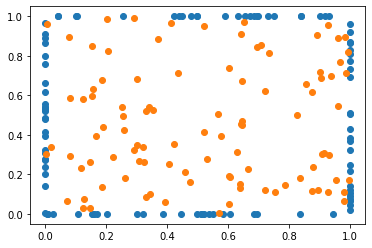

In [47]:
data = laplace.sampleData(interiorPointCount, boundaryPointCount)
xInt = torch.from_numpy(data['xInt']).float()
xBound = torch.from_numpy(data['xBound']).float()
plt.scatter( xBound[:,0], xBound[:,1] )
plt.scatter( xInt[:,0], xInt[:,1] );

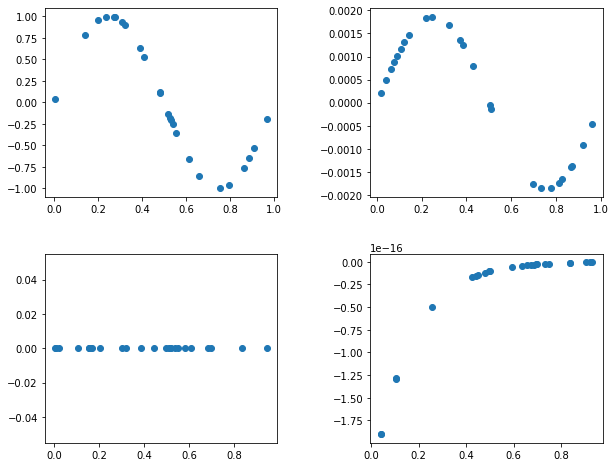

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
axs = axs.flatten()
for ax, idx, coord in zip(axs, range(4), [1,1,0,0]):
    ax.scatter( data['xBound'][idx*25 : (idx+1)*25, coord], data['yBoundCondition'][idx*25 : (idx+1)*25] )
plt.subplots_adjust(wspace=0.4, hspace=0.3);

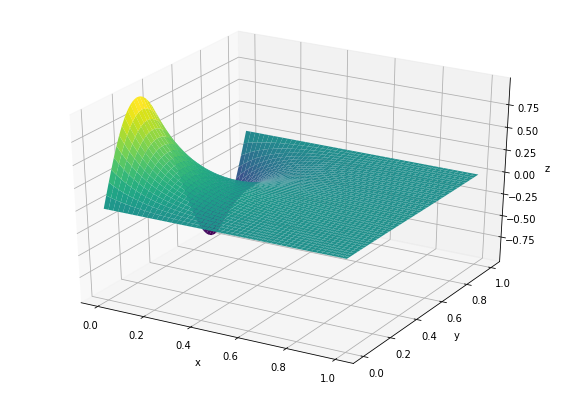

In [49]:
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)

X, Y = np.meshgrid(x, y)
Z = laplace.analyticalSolution([X, Y])

fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

## Adam optimizer

In [50]:
laplace.train(interiorPointCount, boundaryPointCount, lossWeight, iterations)

0 / 3000, loss:4.09e-01
1000 / 3000, loss:7.65e-02
2000 / 3000, loss:2.88e-02


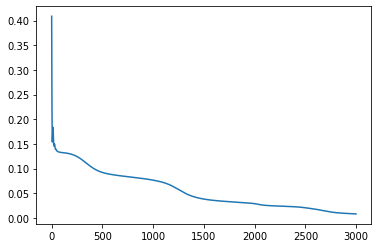

In [51]:
plt.plot( laplace.network.training_loss );

In [52]:
laplace.predict(interiorPointCount, boundaryPointCount, lossWeight)

12.970207923748852

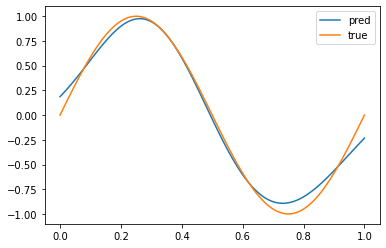

In [53]:
x0 = 0
plt.plot(np.linspace(0, 1, 100), laplace.network.model(torch.tensor([x0 * np.ones(100), np.linspace(0, 1, 100)]).T.float()).detach(), label='pred')
plt.plot(np.linspace(0, 1, 100), laplace.analyticalSolution(torch.tensor([x0 * np.ones(100), np.linspace(0, 1, 100)])), label='true')
plt.legend();

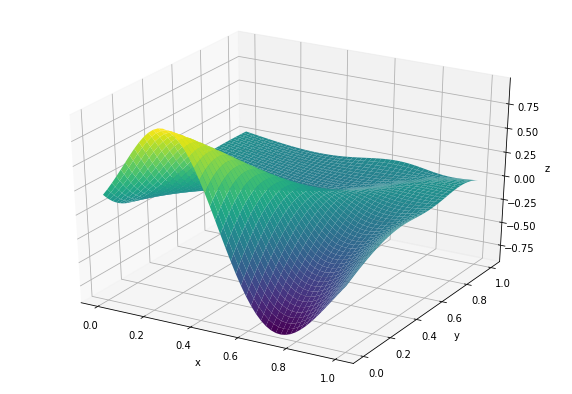

In [54]:
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)

X, Y = np.meshgrid(x, y)
Z = laplace.network.model(torch.tensor([X, Y]).T.float()).detach().numpy()[:,:,0]
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

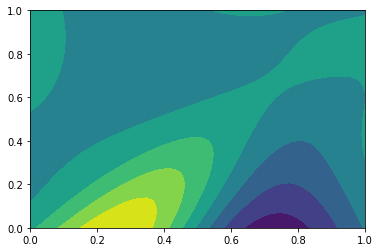

In [55]:
fig, ax = plt.subplots()
ax.contourf(X, Y, Z);

In [ ]:
# can we plot the error?

## LBFGS optimizer

In [70]:
network = NeuralNetNewtonMethod([2, 10, 1], ActivationFunction.Sigmoid, **{'max_iter': 40})
laplace = Laplace_2d(frequency=frequency, lossWeight=lossWeight, network=network)
laplace.train(interiorPointCount, boundaryPointCount, lossWeight, iterations=10)

0 / 10


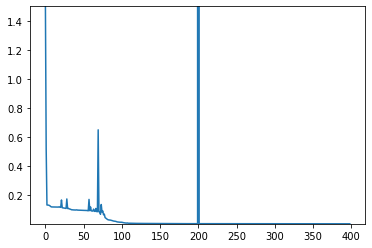

In [71]:
plt.plot( laplace.network.training_loss );
plt.ylim( laplace.network.training_loss[-1], laplace.network.training_loss[0]);

In [72]:
laplace.predict(interiorPointCount, boundaryPointCount, lossWeight)

11.676769072490156

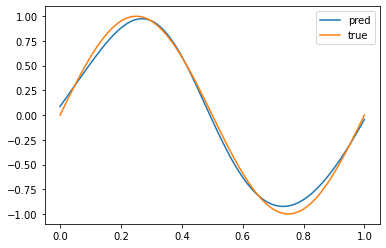

In [73]:
plt.plot(np.linspace(0, 1, 100), laplace.network.model(torch.tensor([np.zeros(100), np.linspace(0, 1, 100)]).T.float()).detach(), label='pred')
plt.plot(np.linspace(0, 1, 100), laplace.analyticalSolution(torch.tensor([np.zeros(100), np.linspace(0, 1, 100)])), label='true')
plt.legend();

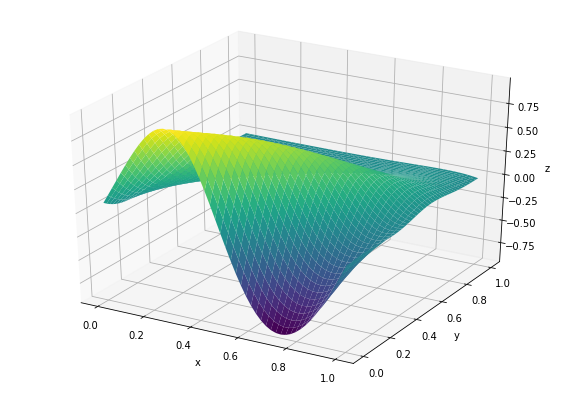

In [74]:
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)

X, Y = np.meshgrid(x, y)
Z = laplace.network.model(torch.tensor([X, Y]).T.float()).detach().numpy()[:,:,0]
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

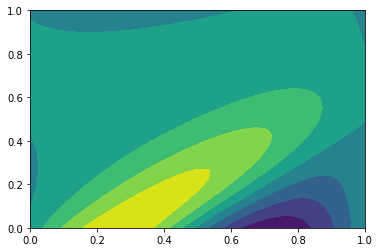

In [75]:
fig, ax = plt.subplots()
ax.contourf(X, Y, Z);